## PyTorch Workflow

Please refer to: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb

Let's explore an exmaple PyTorch end-to-end workflow.

1. data (prepare and load)
2. build model
3. fitting the model to data (training)
4. make predictions and evaluate a model
5. save and load a model
6. putting it all together

In [285]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.7.0'

### 1. Data (Preparing and Loading)

Machine learning is a game of two parts:

1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.

We'll use **linear regression** to create the data with *known* parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using **gradient descent**.

In [286]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
torch.manual_seed(42)
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
error = 0.05 * torch.randn(size=(len(X), 1))
y = bias + weight * X + error

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3963],
         [0.3884],
         [0.3730],
         [0.2367],
         [0.3899],
         [0.3083],
         [0.3818],
         [0.3178],
         [0.3744],
         [0.5084]]))

### Splitting data into training and testing

We could randomly split training/testing data using `train_test_split` from the `sklearn.model_selection`:

In [287]:
from sklearn.model_selection import train_test_split

# X, y: your features and labels (arrays, lists, DataFrames, etc.)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% test, 80% train
    shuffle=True,        # shuffle before splitting (True by default)
    random_state=42      # for reproducibility; use any integer or omit for true randomness
)

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


For now, we let the first 80% of the data as training and the remaining 20% as testing.

In [288]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

#### Visualize data

In [289]:
def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(8, 6))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=16, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=16, label="Testing data")

  # Are there predictions
  if predictions is not None:
    # Plot predictions in red (predictions in test data)
    plt.scatter(test_data, predictions, c="r", s=16, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

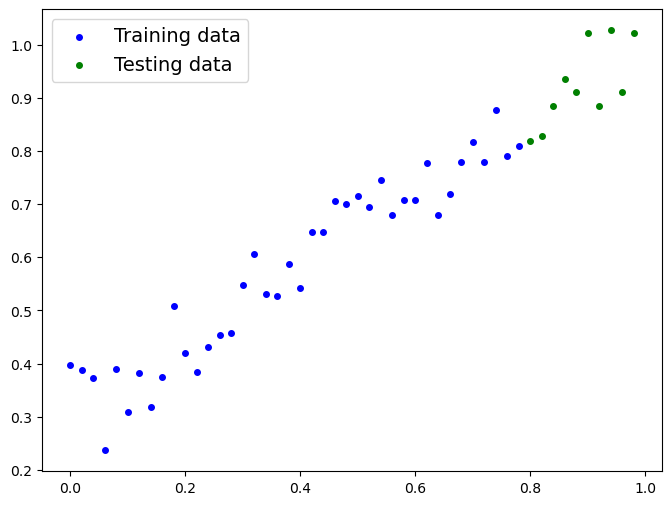

In [290]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test)

### 2. Build model

Our first PyTorch model using OOP (Object Oriented Program).

In [291]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                            requires_grad=True, # <- can we update this value with gradient descent?
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                         requires_grad=True, # <- can we update this value with gradient descent?
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # <- "x" is the input data (e.g. training/testing features)
    # the colon here (x: torch.Tensor) is a "type hint"
    # the arrow here (-> torch.Tensor) is a "return type hint"
    return self.weights * x + self.bias

### PyTorch model building essentials


| PyTorch modules       | What does it do?    |
|:-----------|:-----------|
| `torch.nn` | Contains all of the building blocks for computational graphs  (essentially a series of computations executed in a particular way).        |
| `torch.nn.Parameter`| Stores tensors that can be used with `nn.Module`. If `requires_grad=True`, gradients (used for updating model parameters via **gradient descent**) are calculated automatically, this is often referred to as **autograd**.     |
| `torch.nn.Module`  | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented.  |
| `torch.optim` | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

#### Check the contents of our PyTorch model

In [292]:
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [293]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference.mode()`

In [294]:
# Making prediction with model_0 (random parameters)
# `inference_mode` disables gradient tracking, making code run faster.
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

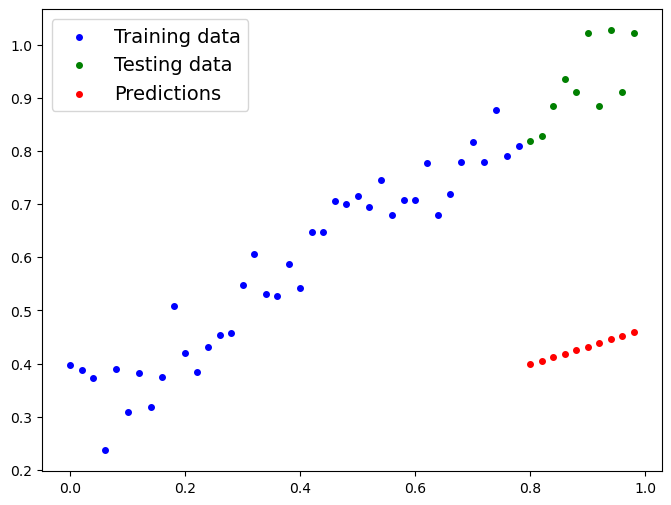

In [295]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test, 
                 predictions=y_preds)

### 3. Train Model

#### Creating a loss function and optimizer in PyTorch

* For **loss function**, see: https://docs.pytorch.org/docs/stable/nn.html#loss-functions

* For **optimizer**, see: https://docs.pytorch.org/docs/main/optim.html

In [296]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # how much the optimizer should change

#### Building a training (and testing) loop in PyTorch

**training**
1. Forward pass
2. Compute the loss
3. Zero gradients
4. Perform backpropagation on the loss
5. Update the optimizer (gradient descent)

**testing**
1. Forward pass
2. Compute the loss
3. Compute other evaluation metrics (optional)

In [297]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 500

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

  ### Training

  # 0. Switch into "train" mode:
  model_0.train()

  # 1. Forward pass: compute model outputs and build computation graph.
  #    Internally calls model_0.forward(X_train).
  y_pred = model_0(X_train)

  # 2. Compute the loss between predictions and ground truth.
  loss = loss_fn(y_pred, y_train)

  # 3. Zero out any previously stored gradients.
  #    PyTorch accumulates gradients by default, so we must clear them each step.
  optimizer.zero_grad()

  # 4. Backward pass: compute new gradients via backpropagation.
  #    Autograd traverses the computation graph in reverse,
  #    storing gradients of parameters in each param.grad.
  loss.backward()

  # 5. Update model parameters using the optimizer’s rule.
  #    For SGD: param.data -= lr * param.grad
  optimizer.step()


  ### Testing
  # 0. Switch into evaluation model
  model_0.eval()

  # Disable gradient tracking for faster, memory‑efficient inference.
  with torch.inference_mode():

    # 1. Forward pass on test data to get predictions.
    test_pred = model_0(X_test)

    # 2. Compute loss on test set:
    test_loss = loss_fn(test_pred, y_test)


  ### Print the results
  if epoch % 20 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.3184804916381836 | MAE Test Loss: 0.4825840890407562 
Epoch: 20 | MAE Train Loss: 0.11274781078100204 | MAE Test Loss: 0.22905251383781433 
Epoch: 40 | MAE Train Loss: 0.06314687430858612 | MAE Test Loss: 0.11276662349700928 
Epoch: 60 | MAE Train Loss: 0.05588054656982422 | MAE Test Loss: 0.07919186353683472 
Epoch: 80 | MAE Train Loss: 0.05265623331069946 | MAE Test Loss: 0.06547452509403229 
Epoch: 100 | MAE Train Loss: 0.05050984025001526 | MAE Test Loss: 0.05898098275065422 
Epoch: 120 | MAE Train Loss: 0.04926322028040886 | MAE Test Loss: 0.05534330755472183 
Epoch: 140 | MAE Train Loss: 0.0484992153942585 | MAE Test Loss: 0.05466127395629883 
Epoch: 160 | MAE Train Loss: 0.04777256399393082 | MAE Test Loss: 0.05388523265719414 
Epoch: 180 | MAE Train Loss: 0.047054219990968704 | MAE Test Loss: 0.05326620489358902 
Epoch: 200 | MAE Train Loss: 0.04641108587384224 | MAE Test Loss: 0.05251558497548103 
Epoch: 220 | MAE Train Loss: 0.04620296508073807 | 

**Note:** In PyTorch, every time you call `loss.backward()`, gradients for each parameter are accumulated into the .grad attribute (i.e. they're summed on top of whatever was there before). This is by design (it lets you implement gradient accumulation over multiple mini-batches), but in the typical "one forward -> one backward -> one step" loop you want to **reset** those old gradients before computing new ones. That's exactly what `optimizer.zero_grad()` does.

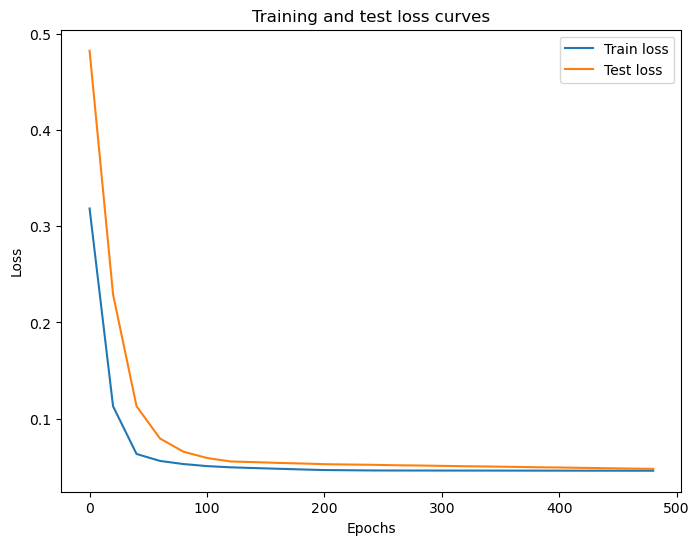

In [298]:
# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [299]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6364]), 'bias': tensor([0.3388])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


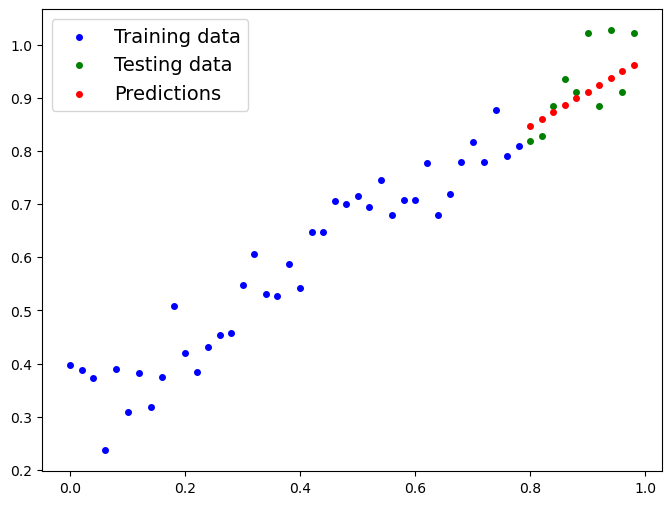

In [300]:
# plot the prediction results
with torch.inference_mode():
  y_preds = model_0(X_test)

plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test, 
                 predictions=y_preds)

### Save (and load) a model in PyTorch

There are three main methods:

1. `torch.save()`: save a PyTorch object in Python's pickle format
2. `torch.load()`: load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`: load a model's saved state dictionary

In [301]:
# Saving the PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


In [302]:
## Load a PyTorch model

# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [303]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
  # perform a forward pass on the test data with the loaded model
    loaded_model_preds = loaded_model_0(X_test)

# Compare previous model predictions with loaded model predictions
# these should be the same
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


---

### 6. Put it all together (use GPU this time)

In [304]:
# Import PyTorch 
import torch
from torch import nn 
import matplotlib.pyplot as plt

# check pytorch version
print(f"torch version is: {torch.__version__}")

# Set device agnostic code
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
print(f"Used device: {device}\n")

torch version is: 2.7.0
Used device: mps



#### 6.1 Data

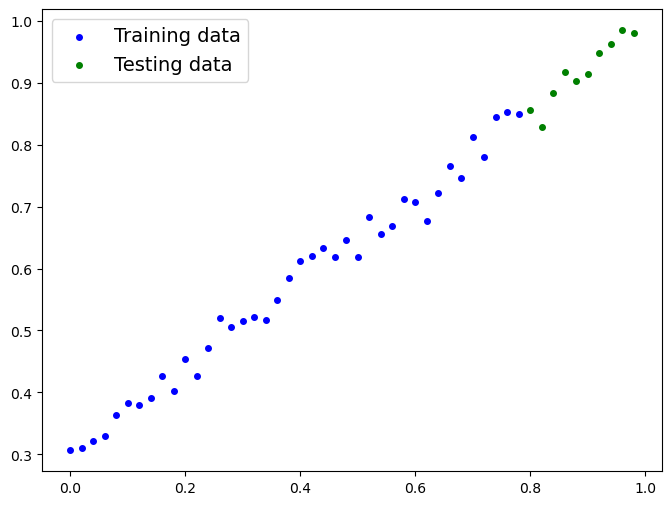

In [305]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create X and y
torch.manual_seed(123)
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
error = 0.02 * torch.randn(size=(len(X), 1))
y = bias + weight * X + error

# Create train/test split
train_split = int(0.8 * len(X)) # 80%-20% of data used for training/testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

# Put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

plot_predictions(train_data=X_train.cpu(), 
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu())

#### 6.2 Building a PyTorch linear model

`class` `torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)`

Applies an affine linear transformation to the incoming data: 

$$y =   x W^{\top} + b$$

In [306]:
# Create linear regression model class
class LinearRegressionModelV2(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
  def __init__(self):
    super().__init__()
    
    # nn.Linear(in_features, out_features) does three things:
    #   1. Allocates a weight tensor of shape [out_features, in_features]
    #   2. Allocates a bias tensor of shape [out_features]
    #   3. Registers both as model parameters for optimization
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # Forward method to define the computation in the model
    return self.linear_layer(x)
  
# Create an instance of the model (this is a subclass of nn.Module)
torch.manual_seed(123)
model_1 = LinearRegressionModelV2()

# check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [307]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

#### 6.3 Training

In [308]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [309]:
torch.manual_seed(123)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

  ### Training
  # 0. Switch into "train" mode:
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Compute the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero out any previously stored gradients
  optimizer.zero_grad()

  # 4. Backward pass
  loss.backward()

  # 5. Update model parameters using the optimizer’s rule.
  optimizer.step()

  ### Testing
  # 0. Switch into evaluation model
  model_0.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  ### Print the results
  if epoch % 50 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().cpu().numpy())
    test_loss_values.append(test_loss.detach().cpu().numpy())
    print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.6985182762145996 | MAE Test Loss: 1.2339286804199219 
Epoch: 50 | MAE Train Loss: 0.23122254014015198 | MAE Test Loss: 0.6315546035766602 
Epoch: 100 | MAE Train Loss: 0.15579652786254883 | MAE Test Loss: 0.39936336874961853 
Epoch: 150 | MAE Train Loss: 0.13354746997356415 | MAE Test Loss: 0.29631176590919495 
Epoch: 200 | MAE Train Loss: 0.11650009453296661 | MAE Test Loss: 0.25084349513053894 
Epoch: 250 | MAE Train Loss: 0.10031884163618088 | MAE Test Loss: 0.21558625996112823 
Epoch: 300 | MAE Train Loss: 0.08414067327976227 | MAE Test Loss: 0.18103349208831787 
Epoch: 350 | MAE Train Loss: 0.06796472519636154 | MAE Test Loss: 0.14577549695968628 
Epoch: 400 | MAE Train Loss: 0.053036607801914215 | MAE Test Loss: 0.11217708885669708 
Epoch: 450 | MAE Train Loss: 0.03954479470849037 | MAE Test Loss: 0.08060301840305328 
Epoch: 500 | MAE Train Loss: 0.027627432718873024 | MAE Test Loss: 0.05802818015217781 
Epoch: 550 | MAE Train Loss: 0.0199654288589954

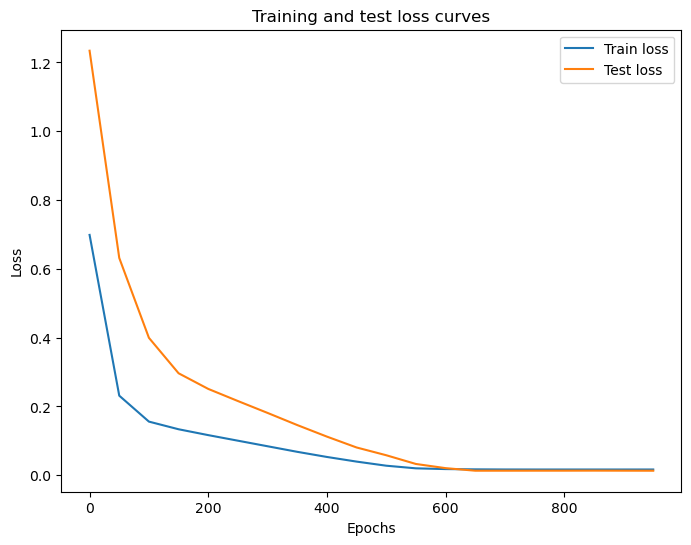

In [310]:
# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

#### 6.4 Make predictions

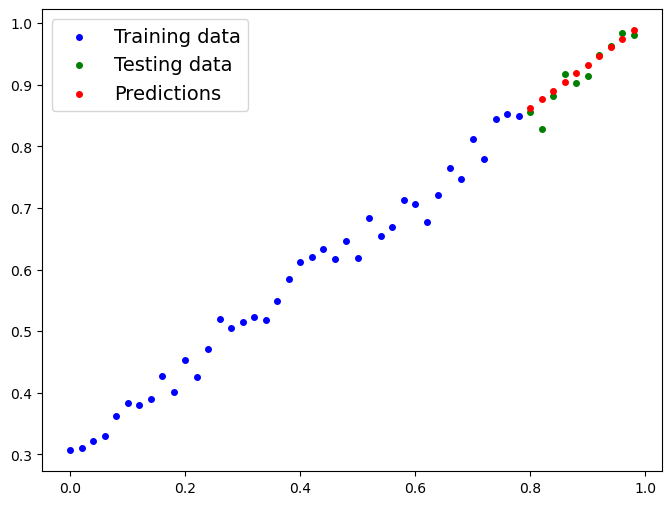

In [311]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)

# Put data on the CPU and plot it
plot_predictions(train_data=X_train.cpu(), 
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu(), 
                 predictions=y_preds.cpu())

#### 6.5 Saving and loading a model

In [312]:
# Save model
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [313]:
# Load and evaluate model

# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
torch.sum(y_preds != loaded_model_1_preds)

tensor(0, device='mps:0')